<a href="https://colab.research.google.com/github/xuanyuw/NOVA1_variation_LFP/blob/main/NOVA1_Variant_LFP_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UC San Diego: Neural Data Science**

# Electrophysiology Profile Differences Between NOVA1 Variant and Wild Type Cortical Organoids During Early Development


##Permissions

Place an X in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

[X] YES - make available

[ ] NO - keep private

## Names

Xuanyu Wu

Can Liu

## Overview

In this project, we compared the spike and local field potentials of wild type and NOVA1 variant cortical organoids at week0, week1, week3, and week7 of their development. The analyses used include spiking rate, inter-spike interval(ISI), inter-event interval coefficient of variation (CV), spike field coherence (SFC), event related LFP spectrum, and cross-frequency phase-amplitude coupling (PAC). Our results are largely coherent with the claim about slow development and high network complexity of NOVA1 organoid in previous studies. However, the limitation on the data sources needs to be addressed.


## Research Question

In this project, we want to investigate the differences in the electrophysiology profiles (spike patterns and LFP properties) of two types of cortical organoids during early stages of neurodevelopment (week 0, week 1, week 3, and week 7).


## Background & Prior Work

Organoids, generated from induced pluripotent stem cells (iPSCs), can mimick various developmental features at the cellular and molecular levels. They allow us to gain access to the initial stages of the living human brain from an unique angle, enabling us to examine the structural, transcriptional, and electrophysical changes going on during development. 

Trujillo et al. used human iPSCs to generate cortical organoids and investigated the transcription profile and oscillatory network dynamics during development [1]. The same group did another study by reintroducing an archaic allele of the neuro-oncological ventral antigen 1 (NOVA1) into iPSCs, to investigate the functional importance of this amino acid [2]. NOVA1 regulates alternative splicing in the developing brain and is highly envolved with synapse formation [3]. The organoids with archaic NOVA1 gene showed slower neurodevelopment, slower proliferation, which led to smaller organoids size relative to human control organoids; they had increased surface complexity of the cells; because NOVA1 is involved in synaptogenesis and neuronal connectivity, NOVA1 archaic organoids expressed lower level of pre- and postsynaptic proteins, leading to altered synaptic protein interaction and neuronal connectivity, and showed higher heterogeneity of the electrophysiological profiles.

While the NOVA1 study delved deep into the transcriptional and molecular analysis, it didn't show much characterization of the electrophysiology properties of the organoids, especially with regards to the local field potential dynamics. We thus became interested in learning and applying some of the developed methods in the prior organoid research and additional online tutorials to further characterize electrophysiological properties of the NOVA1 organoids, and also comparing the results from both organoids and checking if our findings are in agreement with the paper.


References:

[1] https://www.cell.com/cell-stem-cell/pdfExtended/S1934-5909(19)30337-6

[2] https://science.sciencemag.org/content/371/6530/eaax2537

[3] https://pubmed.ncbi.nlm.nih.gov/16041372/

## Hypothesis 

Based on previous findings about the NOVA1 variant cortical organoid, we hypothesize that throughout the included time period, the NOVA1 variant will have larger network complexity and thus more chaotic activity patterns. We also think that the NOVA1 variant samples will generate fewer spikes and less pronounced neural oscillations due to its slow development. 

## Datasets

**Data set 1**

Dataset Name: CTC

Link to the dataset: 

https://drive.google.com/drive/folders/1uK0Q5XRFpBfSb-dlOkMxOQcO-zcLFSlk?usp=sharing

Number of observations: 37 recordings

This dataset contains 37 electrophysiology recordings across different developmental stages of CTC organoids, in .mat format. The folder name/file name indicates the date of the recording. Each file comtains preprocessed electrophysiology data including sampling rate (original, downsampled), local field potentials, spike average, spike count, spike time, spike shape, and time stamps.

**Data set 2**

Dataset Name: NOVA1

Link to the dataset: 

https://drive.google.com/drive/folders/1zjIS_uk7ZBJAZ5DpHqqNtBIR--fCsCMQ?usp=sharing

Number of observations: 11 recordings

This dataset contains 11 raw electrophysiology recordings across different developmental stages of NOVA1 mutant organoids, after preprocessing they have the same format as data set 1.

Same electrophysiological features are contained in both data set, including information about spikes and local field potentials, and the organoid were maintained and the data were colleted in the same way, with the only difference being the variation in the NOVA1 gene. This allow us to compare the electrophysiological properties of these two groups of organoids across neurodevelopment.

## Data Cleaning & Wrangling



We gained access to the data from the group who has done the orginal organoid work. After using the preprocessing code (p1_convertpreprocess.m, from https://github.com/voytekresearch/OscillatoryOrganoids/tree/master/functions), raw multi-electrode array data were converted, downsampled, and spikes and lfp were detected and extracted. Each recording contains data from 12 wells, with 64 recording channels in each well.

In order to load .mat files into jupyter notebook, we used the h5py package to interface with the HDF5 binary data format. Data were maintained as shared google drives, so team members can access the data and the notebook through google colab.

Due to the limitation on the specific time of data collection during the development, we decided to select data from week 0, week 1, week 3, and week 7 that both datasets includes and can thus match up. However, because we only have the date that the data was collected, we could only infer the respective developmental stage (we assumed the earliest recording to be at week 0 for both datasets) but could not be 100% sure about the specific time into development. 

First, we need to connect to the database and import the packages needed.

In [1]:
# Mount drive to access dataset
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [63]:
# import packages
import glob
import h5py
import re
import json 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import scipy as sp

from scipy.io import loadmat
from tqdm import tqdm
from scipy.stats import pearsonr, chi2
from scipy.signal import welch, spectrogram, butter, sosfiltfilt, sosfreqz, hilbert
from pylab import *
from matplotlib import cm 

Since some values will be kept constant throughout the entire project, we can make them global variables.

In [3]:
global fs_orig, num_channels, num_wells, event_start, event_end, event_len, fs_ds
fs_orig = 12500
fs_ds = 1000
num_channels = 64
num_wells = 12
event_start = -0.5
event_end = 2.5
event_len = int(fs_ds*(abs(event_start)+abs(event_end)))

In [4]:
# load NOVA1 data
nova_fns = sorted([mat for mat in glob.glob('/content/drive/My Drive/NOVA1_LFP/NOVA1/44-136_LFP/*.mat')])
ctc_fns = ['/content/drive/My Drive/NOVA1_LFP/CTC/'+ fn for fn in ['LFP_Sp_010617.mat', 'LFP_Sp_011317.mat', 'LFP_Sp_012717.mat', 'LFP_Sp_022417.mat']]
nova_files = [h5py.File(fn, 'r') for fn in nova_fns]
ctc_files = [h5py.File(fn, 'r') for fn in ctc_fns]

## Data visualization

Since data include both spiking and the lfp, we can visualize what each looks like through plotting some examplary traces. 

Firstly, we can plot the lfp data of CTC organoid from week 3, from well 12, which recorded relatively more network events.

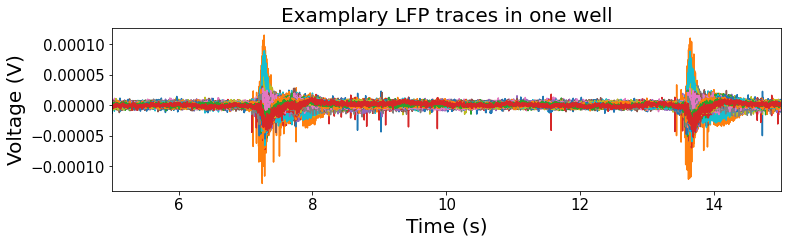

In [8]:
# plot one well lfp trace
# load file

file = h5py.File(ctc_fns[1], 'r') # load recording
ref = file['LFP'][0][11] # well number
lfp = np.array(file[ref])
x = lfp[5]
Fs = 1000. # sampling rate
t = np.arange(0,len(x)/Fs,1/Fs) # time array

plt.figure(figsize=(12,3))
for i in range(64):
  x = lfp[i]
  t_plot = [5,15] # time window to look at activities
  t_plot_idx = np.where(np.logical_and(t>=t_plot[0],t<t_plot[1]))[0]

  plt.plot(t[t_plot_idx], x[t_plot_idx])

#plt.figure(figsize=(12,3))
  plt.title('Examplary LFP traces in one well',size=20)
  plt.yticks(size=15)
  plt.xticks(size=15)
  plt.xlabel('Time (s)',size=20)
  plt.ylabel('Voltage (V)',size=20)
  plt.xlim((t_plot))


Here is a plot of all lfp traces in one well overlayed. We can observe that during network events, lfp will show peaks with very large but different amplitudes, some in positive direction and some in negative direction. The lfp shape almost resembles the shape of extracellularly recorded action potentials, which makes us wonder if the lfp collected from the organoids, due to its fewer cell numbers and less prominent/organized connectivity structures, may reflect different kinds of collective synaptic activities compared to normal lfp data.

Next, we can plot the population spikes detected during the same period of time.

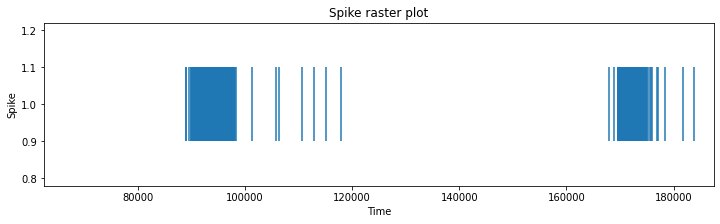

In [9]:
# plot populational spikes detected on 1 channel

spikes = file['spikes']
spks = np.array(file[spikes[1,11]])

plt.figure(figsize=(12,3))
plt.eventplot(spks,linelengths = 0.2)
# Provide the title for the spike raster plot
plt.title('Spike raster plot')
plt.xlabel('Time')
plt.xlim([5*12500,15*12500])
plt.ylabel('Spike')
plt.show()

From this plot, we can see that a prominent cluster of population firing coincides with the increase in the lfp amplitude; outside the network event, there isn't any spikes detected. The network is likely very connected, with very few cells that spontaneously fire at a constant frequency.

## Data Analysis & Results

We want to begin by looking at the properties of the spikes recorded by the  multi-electrode arrays (MEA). Note that these spikes do not represent single-unit action potentials. 

### Spiking Rate





Firstly, we compare the spiking rates of the two groups at each time points. Since we have 12 wells on each MEA and 64 channels in each well, resulting 768 recorded traces in total, we decide to calculating the firing rate by finding the channel that has the most spike and then use its spiking rate to represent the spiking rate of the whole recording. The purpose of this choise is to avoid double-counting the spikes picked up by multiple channels. 

In [10]:
def calc_spk_rate(file):
  """
  calculate the spiking rate of signals recorded for all the wells and channels of one recording file.
  input:
    file: file loaded by h5py
  return: 
    spiking rate
  """
  total_spks = np.array(file['spike_cnt']).max()
  total_time = max(file['t_s'][0])
  return total_spks/total_time

sr_nova = [calc_spk_rate(file) for file in nova_files]
sr_ctc = [calc_spk_rate(file) for file in ctc_files]

Text(0.5, 1.0, 'Spiking rate of nova1 variant and wild type')

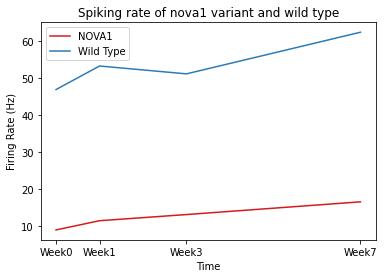

In [11]:
# plot the spiking rate for two groups
plt.plot([1, 2, 4, 8], sr_nova, c='#D7191C', label='NOVA1')
plt.plot([1, 2, 4, 8], sr_ctc, c='#2C7BB6', label='Wild Type')
plt.xticks(labels=['Week0','Week1','Week3','Week7'], ticks=[1, 2, 4, 8])
plt.ylabel('Firing Rate (Hz)')
plt.xlabel('Time')
plt.legend(loc='best')
plt.title('Spiking rate of nova1 variant and wild type')

The plot above shows the the change of spiking rate of the two groups over time. The spiking rate of the wild type group is much higher than that of the NOVA1 variant group at all of the time points. Although the spiking rates of two groups both increase over time, the increasing rate of the wild type group is greater than that of NOVA1 vairant group, which potentially proofs our hypothesis about slow development in the NOVA1 group. In addition, the NOVA1 variants proliferate slower than the wild types as reported by previous study (Trujillo et al., 2021). The low spike rate probably reflects the low cell count as well. 



### Inter-Spike interval (ISI)

Then, we look at the inter-spike interval (ISI). ISI is normally influenced by three factors: intrinsic properties of the neurons, network interactions, and the nature of the input. Since all activities here are spontaneous activities, we mainly focus on the first two. 

In [12]:
def calculate_isi(file):
  """
  Caluculate inter-spike interval
  input:
    file: file loaded by h5py
  return: 
    inter-spike interval of all the channels in a 1D array
  """
  all_isi = []
  spikes = np.array(file['spikes'])
  for i in range(num_wells):
    isi = []
    for j in range(num_channels):
      spks = np.array(file[spikes[j, i]]).flatten()
      spks_diff = np.diff(spks).flatten()
      if len(spks_diff)>1:
        isi.append(spks_diff)
    if len(isi)>0:
      isi = np.hstack(isi)
      all_isi.append(isi)
  return np.hstack(all_isi)

# Calcualte ISI for all recordings
nova_isi = [calculate_isi(file) for file in nova_files]
ctc_isi = [calculate_isi(file) for file in ctc_files]

Text(0.5, 0.98, 'Distribution of inter-spike intervals')

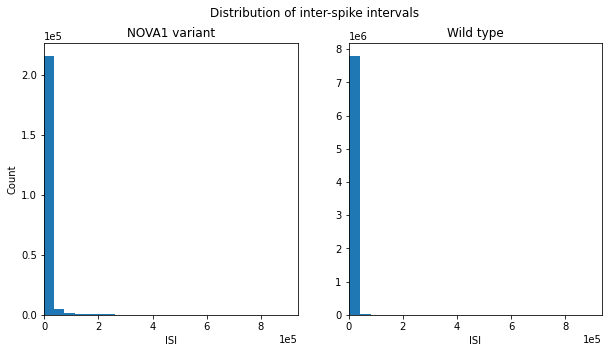

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(np.hstack(nova_isi),bins=50)
plt.title('NOVA1 variant')
plt.xlabel('ISI')
plt.ylabel('Count')
upper_lim = np.max([max(i) for i in nova_isi])/2
plt.xlim([0, upper_lim])
plt.ticklabel_format(axis="both", style="sci",scilimits=(0,0))
plt.subplot(1, 2, 2)
plt.hist(np.hstack(ctc_isi),bins=50)
plt.title('Wild type')
plt.xlabel('ISI')
plt.xlim([0, upper_lim])
plt.ticklabel_format(axis="both", style="sci",scilimits=(0,0))
plt.suptitle('Distribution of inter-spike intervals')

In [14]:
nova_isi_mean = np.mean(np.hstack(nova_isi))
ctc_isi_mean = np.mean(np.hstack(ctc_isi))
nova_isi_std = np.std(np.hstack(nova_isi))
ctc_isi_std = np.std(np.hstack(ctc_isi))
nova_isi_min = np.min(np.hstack(nova_isi))
ctc_isi_min = np.min(np.hstack(ctc_isi))
nova_isi_max = np.max(np.hstack(nova_isi))
ctc_isi_max = np.max(np.hstack(ctc_isi))

nova_mean_numspk = np.mean([len(i) for i in nova_isi])
ctc_mean_numspk = np.mean([len(i) for i in ctc_isi])


pd.DataFrame({'Mean':[nova_isi_mean, ctc_isi_mean],
              'Std': [nova_isi_std, ctc_isi_std],
              'Min':[nova_isi_min, ctc_isi_min],
              'Max':[nova_isi_max, ctc_isi_max],
              'Mean interval count':[nova_mean_numspk, ctc_mean_numspk]
              }, index=['NOVA1', 'Wild Type'])

,Mean,Std,Min,Max,Mean interval count
NOVA1,8443.815009,39158.165273,26.0,1873070.0,56355.50
Wild Type,742.263161,9850.596661,14.0,2046075.0,1956475.75


In the plot and the table above, it is clear that the NOVA1 variant group has higher variance than wild type group does. There are two possible explanations behind this result:
  1. NOVA1 has more diverse cell types, which means there are many different subpopulations of neurons that have various properties. 
  2. the excitatory and inhibitory inputs create a balance, leading to a fluctuating total drive

The table also shows that the wild type group has shorter ISI and more intervals(more spikes) than the NOVA1 group, confirming our previous conclusion that NOVA1 variant cortical organoid develops slower than the wild type cortical organoid.

### Inter-Event Interval Coefficient of Variation (CV)



The inter-event interval coefficient of variation (CV) is a method to quantify network complexity. The CV is calculated by dividing the standard deviation of the inter-event interval by its mean. 

An event is defined using the following steps:
  1. the spiking rate is at least 1 spike/second
  2. the event is at least 1 second apart from the last event

Since only LFP amplitude data is available in the dataset, we do not consider the amplitude of each spike when defining events. 

After finding the event onset points that satisfy the criteria above, 0.5 seconds before and 2.5 seconds after each onset points are set as the start and the end points of each event because the events almost always diminish 2.5 seconds after the onsest.


In [15]:
def extract_events(well_id, channel_id, file):
  """
  Extract all the events onset point (t0) from the signals of one channel
  input:
    well_id: the ID of the well (0-11) on the MEA array
    channel_id: the ID of the channel (0-63) in the well
    file: file loaded by h5py
  return: 
    all the event onset points that satisfy the specified criteria
  """
  events_t0 = []
  spikes = np.array(file['spikes'])
  spks = np.array(file[spikes[channel_id, well_id]]).flatten()
  spks = (spks*fs_ds/fs_orig).astype('int') #convert index according to down-sampled sampling rate
  # faster way to check if spike rate is over 1Hz
  prev = spks[:-2]
  post = spks[2:] 
  diff = post - prev
  events_freq = prev[diff<event_len]
  # faster way to check if distance between event is greater than 1 second
  freq_prev = events_freq[:-1]
  freq_post = events_freq[1:]
  dist = freq_post - freq_prev
  t0_index = dist>(event_end+1)*fs_ds
  if sum(t0_index) > 0:
    events_t0 = np.insert(freq_post[t0_index], 0, freq_prev[0])
  return events_t0

def calculate_iei_cv(file):
  """
  Calculate inter-event interval(IEI) coefficient of variation (CV) in one recording
  input:
    file: file loaded by h5py
  output:
    all_cv: CV for all channels in the recording as a 1D list
  """
  all_cv = []
  #loop throught all channels
  for i in range(num_wells):
    iei = []
    for j in range(num_channels):
      events_t0 = extract_events(i, j, file) #extract event onsets
      iei.append(np.diff(events_t0).flatten()) #calculate IEI
    if len(iei)>0:
      iei = np.hstack(iei)
      # calculate CV
      iei_mean = np.nanmean(iei)
      iei_std = np.nanstd(iei)
      all_cv.append(iei_std/iei_mean)
    else:
      all_cv.append(np.nan)
  return all_cv



In [16]:
nova_cv = [calculate_iei_cv(file) for file in nova_files]
ctc_cv = [calculate_iei_cv(file) for file in ctc_files]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(0.4, 1.0)

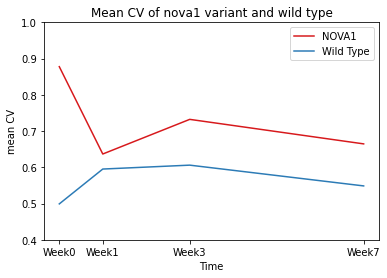

In [17]:
nova_mean_cv = [np.nanmean(cv) for cv in nova_cv]
ctc_mean_cv = [np.nanmean(cv) for cv in ctc_cv]

plt.plot([1, 2, 4, 8], nova_mean_cv, c='#D7191C', label='NOVA1')
plt.plot([1, 2, 4, 8], ctc_mean_cv, c='#2C7BB6', label='Wild Type')
plt.xticks(labels=['Week0','Week1','Week3','Week7'], ticks=[1, 2, 4, 8])
plt.ylabel('mean CV')
plt.xlabel('Time')
plt.legend(loc='best')
plt.title('Mean CV of nova1 variant and wild type')
plt.ylim([0.4, 1])

The plot above shows the average CV for NOVA1 variant and Wild Type at each time point. It illustrates that the NOVA1 variant does have higher network complexity even during early development (0 to 7 weeks). 

It is slightly surprising to see that two groups all decrease in network complexity over time while it should increase according to previous findings for week 10 to 40 wild type cortical organoids (Trujillo et al., 2019). It might be the case that this decreasing trend is temporary and insignificant. But it is also possible that the network complexity increase again from week 7 to week 10 for the wild type organoid. As for the NOVA1 variant group, it is hard to conclude the network complexity development beyond week7 unless more data is provided.

### Spike Field Coherence (SFC)

The Spike field coherence (SFC) mesures the synchronization between the phase of the local field potential (LFP) and the spike times. Therefore, it is a method for evaluating neural oscillations. With this analysis, we want to see if any early signs of neural oscillation arise from the two groups of cortical organoids.

In [18]:
def extract_lfp_seg(lfp, events_t0):
  """
  extract event segments from LFP data
  input:
    lfp: LFP signal from one channel as an np.array
    events_t0: events onset points got from function *extract_events*
  output:
    lfp_events: LFP event segments as ndarray with shape (number of events, event length)
  """
  all_start = np.array(events_t0).astype('int') + int(event_start*fs_ds)
  all_end = np.array(events_t0).astype('int') + int(event_end*fs_ds)
  # eliminate incomplete event 
  lfp_events = np.vstack([lfp[all_start[i]:all_end[i]] for i in range(len(events_t0)) if len(lfp[all_start[i]:all_end[i]])==event_len])
  return lfp_events

def extract_spks_seg(spks, num_events):
  """
  extract spks within an event
  input:
    spks: array with all spike time points
    num_events: total number of events
  output:
    spks_events: spike event segments as ndarray with shape (number of events, event length)
          in each row, the value is 1 if there is a spike at that point, 0 otherwise.

  """
  spks_events = np.zeros((num_events, event_len))
  for i in range(num_events):
    # fast way to find the corresponding spike index within an event
    shifted_spks = spks - i + int(event_start*fs_ds)
    shifted_spks = shifted_spks[np.logical_and(shifted_spks>=0, shifted_spks<=int(event_end*fs_ds))]
    # change the value at indices with spikes to 1
    spks_events[i, shifted_spks] = 1
  return spks_events
  
def calculate_sfc(well_id, channel_id, file):
  """
  calculate SFC for a single channel
  input:
    well_id: the ID of the well (0-11) on the MEA array
    channel_id: the ID of the channel (0-63) in the well
    file: file loaded by h5py
  output:
    SFC score of that channel
  """
  # https://mark-kramer.github.io/Case-Studies-Python/11.html
  events_t0 = extract_events(well_id, channel_id, file)
  N = event_len
  # make sure there are events in this channel
  if len(events_t0)>0:
    lfp = np.array(file[np.array(file['LFP']).flatten()[well_id]])[channel_id, :]
    lfp_events = extract_lfp_seg(lfp, events_t0)
    num_events = lfp_events.shape[0]

    spikes = np.array(file['spikes'])
    spks = np.array(file[spikes[channel_id, well_id]]).flatten()
    spks = (spks*fs_ds/fs_orig).astype('int') #convert spike index to down-sampled lfp index 
    spks_events = extract_spks_seg(spks, num_events)

    t = np.array(file['t_ds'])[0]                       
    K = num_events                                                                  
    dt = t[1]-t[0]                                     
    SYY = zeros(int(N/2+1))                      # Variable to store field spectrum.
    SNN = zeros(int(N/2+1))                      # Variable to store spike spectrum.
    SYN = zeros(int(N/2+1), dtype=complex)              # Variable to store cross spectrum.

    for k in arange(K):                                 # For each trial,
        yf = rfft((lfp_events[k,:]-mean(lfp_events[k,:])) *hanning(N))    # Hanning taper the field,
        nf = rfft((spks_events[k,:]-mean(spks_events[k,:])))                # ... but do not taper the spikes.
        SYY = SYY + (real(yf*conj(yf)))/K           # Field spectrum
        SNN = SNN + (real(nf*conj(nf)))/K           # Spike spectrum
        SYN = SYN + (yf*conj(nf))/K        # Cross spectrum
    cohr = real(SYN*conj(SYN)) / SYY / SNN              # Spike-field coherence
    return cohr
  return zeros(int(N/2+1))

def mean_well_sfc(file):
  """
  calculate the average sfc for each well in a recording
  input:
    file: file loaded by h5py
  output:
    all_sfc: a list that contains the mean sfc for each well
  """
  all_sfc = []
  for well_id in range(num_wells):
    well_sfc = []
    for channel_id in range(num_channels):
      cohr = calculate_lfp(well_id, channel_id, file)
      well_sfc.append(cohr)
    all_sfc.append(np.nanmean(well_sfc))
  return all_sfc

In [19]:
# Takes a long time to run, save the result to a file
rerun_sfc = 0
if rerun_sfc:
  nova_sfc = []
  print('Calculating sfc of NOVA1 variant samples...')
  for file in tqdm(nova_files):
    nova_sfc.append(mean_well_sfc(file))

  ctc_sfc = []
  print('Calculating sfc of wild type samples...')
  for file in tqdm(ctc_files):
    ctc_sfc.append(mean_well_sfc(file))
    
  with open('/content/drive/My Drive/NOVA1_LFP/nova_sfc.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % sfc for sfc in nova_sfc)

  with open('/content/drive/My Drive/NOVA1_LFP/ctc_sfc.txt', 'w') as filehandle:
    filehandle.writelines("%s\n" % sfc for sfc in ctc_sfc)

In [20]:
# load pre-calculated file to save time
rerun_sfc = 0
if not rerun_sfc:
  p = re.compile(r'\d+\.\d+')  # Compile a pattern to capture float values
  nova_sfc = []
  with open('/content/drive/My Drive/NOVA1_LFP/nova_sfc.txt', 'r') as filehandle:
    for line in filehandle.readlines():
      nova_sfc.append([float(i) for i in p.findall(line)])

  ctc_sfc = []
  with open('/content/drive/My Drive/NOVA1_LFP/ctc_sfc.txt', 'r') as filehandle:
    for line in filehandle.readlines():
      ctc_sfc.append([float(i) for i in p.findall(line)])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Distribution of Average Spike Field Coherence of Each Well')

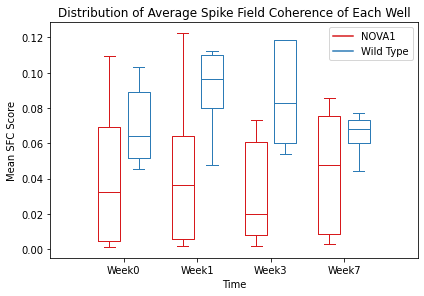

In [22]:
# Plot pretty box plot for SFC data, modified from https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots
ticks = ['Week0','Week1','Week3','Week7']
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

nova_sfc = [list(np.array(sfc)[np.nonzero(sfc)[0]]) for sfc in nova_sfc]
ctc_sfc = [list(np.array(sfc)[np.nonzero(sfc)[0]]) for sfc in ctc_sfc]

plt.figure()
bpl = plt.boxplot(nova_sfc, positions=np.array(range(len(nova_sfc)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(ctc_sfc, positions=np.array(range(len(ctc_sfc)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='NOVA1')
plt.plot([], c='#2C7BB6', label='Wild Type')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Mean SFC Score')
plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.title('Distribution of Average Spike Field Coherence of Each Well')

The SFC score in the plot above indicates how much of the spike field coherence is happening to a certain phase. Although it does not tell us which phase the spikes are locked into, it gives us a rough idea about the general oscillation level. 

Among all the time points, the NOVA1 variant organoid has lower yet more variable SFC than the wild type organoid does. The SFC score of the wild type is more compact at week 7, which could suggest that the oscillation in the wild type organoid is becoming stable across different locations within a spatial range (across wells). However, the NOVA1 variant SFC does not have a similar trend. Therefore, there might be some early oscillation emerging from the wild type organoid during the early development, while the NOVA1 variant organoid fails to generate the same level of ocillation in the same developing period.

### Compare event related LFP spectrum

Beside looking at spike-phase relationships, we also want to look into the frequency domain of the lfp signals, and see if prominent power band might be manifested during network events, which might indicate some underlying neural mechanisms during populational spikings.

Since network events happened less frequently, looking at the power spectrum across the entire recording session might average out thus mask the presense of certain oscillatory activities. Thus, we collected lfp's around the network event (0.5s before to 2.5s after the network event onset), and see if certain frequency band stands out, and how the power spectrum changes across development stage, and differs between the two organoid groups.

In [23]:
def all_lfp(file):
  """
  Collect all LFP traces for all events in a file and take the average
  input:
    file: file loaded by h5py
  output:
    avg_event_lfp: the average of all LFP trace during events in this file as an numpy array with shape (1*3000)
  """
  all_lfp_events = np.empty([1,3000])

  for i in range(num_wells):
    ref = file['LFP'][0][i] # well number 
    lfp = np.array(file[ref])
    if lfp.shape[0] == num_channels: # if lfp exist   
      for j in range(num_channels):
        events_t0 =  extract_events(i,j, file)
        if len(events_t0)>0: # if event exist
          lfp_events = extract_lfp_seg(lfp[j], events_t0)    
          all_lfp_events = np.vstack((all_lfp_events,lfp_events))

  all_lfp_events = np.delete(all_lfp_events, 0, 0)
  avg_event_lfp = np.mean(all_lfp_events, axis=0)

  return avg_event_lfp


In [24]:
# collect all lfp's around events
nova_lfp_events = [all_lfp(file) for file in nova_files]
ctc_lfp_events = [all_lfp(file) for file in ctc_files]

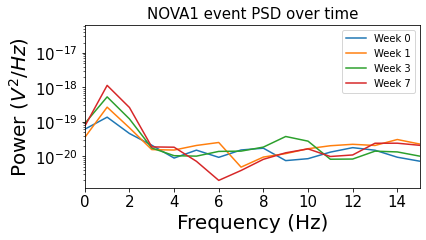

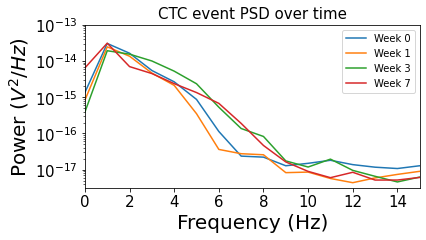

In [25]:
# plot event-related lfp across time
# code adapted from https://github.com/voytekresearch/Tutorials/blob/master/Exploring%20a%20neural%20oscillation.ipynb

plt.figure(figsize=(6, 3))

for i in range(len(nova_lfp_events)):
  f, psd = welch(nova_lfp_events[i], 1000, nperseg=1000) 
  # Plot the power spectrum
  plt.semilogy(f,psd)

plt.xlim((0,15))
#plt.ylim((10**(-18),10**(-16)))
plt.yticks(size=15)
plt.xticks(size=15)
plt.ylabel('Power ($V^{2}/Hz$)',size=20)
plt.xlabel('Frequency (Hz)',size=20)
plt.title('NOVA1 event PSD over time',size=15)
plt.legend(['Week 0', 'Week 1','Week 3','Week 7'])

plt.figure(figsize=(6, 3))

for i in range(len(ctc_lfp_events)):
  f, psd = welch(ctc_lfp_events[i], 1000, nperseg=1000) 
  # Plot the power spectrum
  plt.semilogy(f,psd)

plt.xlim((0,15))
plt.ylim((10**(-17.5),10**(-13)))
plt.yticks(size=15)
plt.xticks(size=15)
plt.ylabel('Power ($V^{2}/Hz$)',size=20)
plt.xlabel('Frequency (Hz)',size=20)
plt.title('CTC event PSD over time',size=15)
plt.legend(['Week 0', 'Week 1','Week 3','Week 7'])

Here in the spectrogram, the x axis is the frequency band, and y axis is the power of signals. Four colors indicate four developmental time points. We can see that during network events, both the CTC and the NOVA1 organoid have increased power in delta band (0-4 Hz). The general power of signal of CTC organoids are a lot higher than that of NOVA1, indicating more pronounced and robust oscillatory events, which might come from the larger organoid size of CTC organoid; the higher power also appear at higher frequencies (4-8 Hz, around theta band), indicating the existence of multiple types of oscillatory activities. As development progresses, NOVA1 event related lfp increases power around 1Hz steadily, which might indicate some underlying developmental mechanisms thus neuronal activities that are maturing through time.


Spectrogram can provide additional information for how the power changes through time (through progression of the network event).

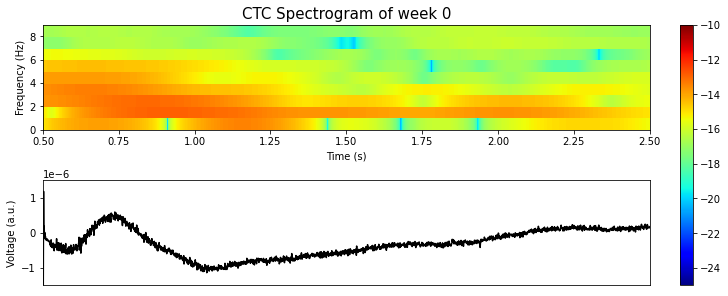

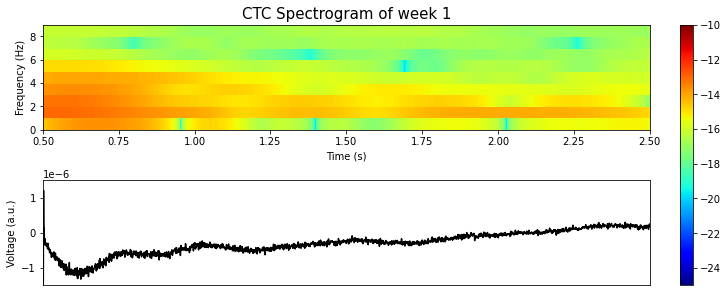

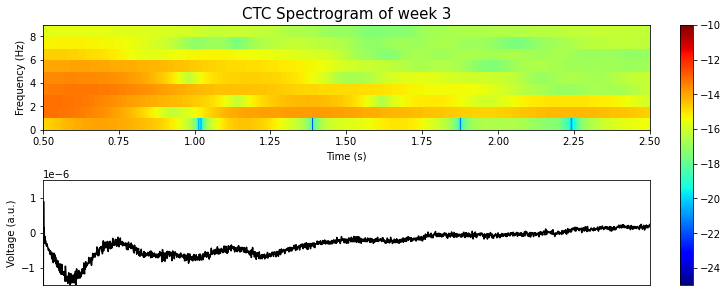

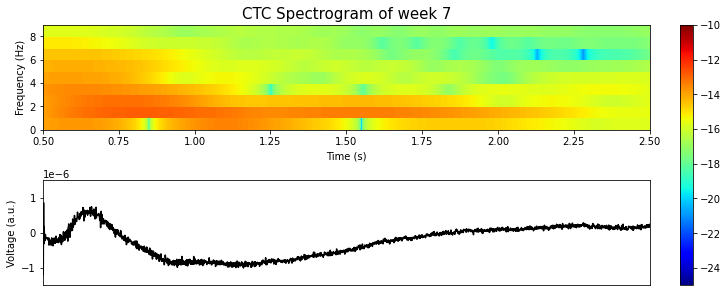

In [60]:
# plot ctc event spectrogram and average lfp trace
week = [0,1,3,7]

for i in range(4):
  # Calculate spectrogram of data in limited range
  f, t_spec, x_spec = spectrogram(ctc_lfp_events[i], fs=fs_ds, window='hanning', nperseg=1000, noverlap=1000-1, mode='psd')
  t = range(3000)

  # Plot spectrogram
  fmax = 10
  fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10,4))
    
  x_mesh, y_mesh = np.meshgrid(t_spec, f[f<fmax])
  axs[0].set_title('CTC Spectrogram of week ' + str(week[i]),size=15)
  pcm = axs[0].pcolormesh(x_mesh, y_mesh, np.log10(x_spec[f<fmax]), cmap=cm.jet, vmin=-25, vmax=-10)
  axs[0].set_xlabel('Time (s)')
  axs[0].set_ylabel('Frequency (Hz)')
  fig.colorbar(pcm, ax=axs[:], location='right', aspect=50)

  axs[1].plot(t,ctc_lfp_events[i],'k')
  axs[1].set_xticks([])
  axs[1].set_ylabel('Voltage (a.u.)')
  axs[1].set_xlim(500, 2500)
  axs[1].set_ylim(-1.5e-6, 1.5e-6)


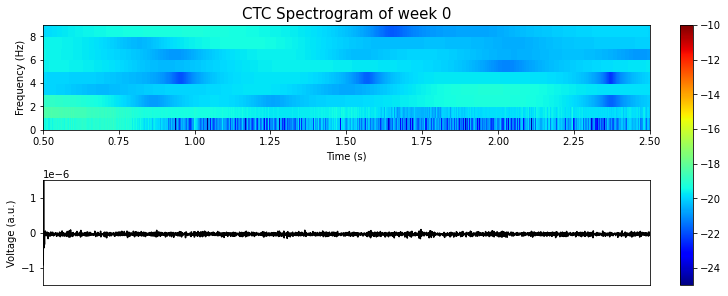

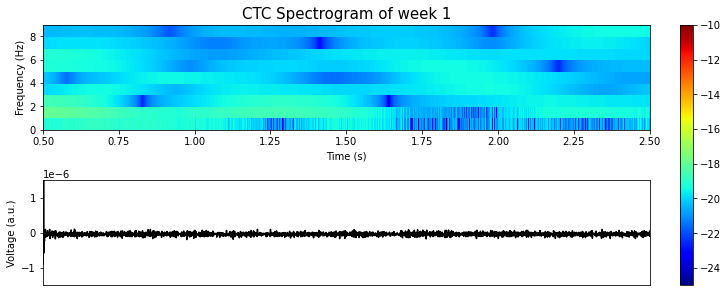

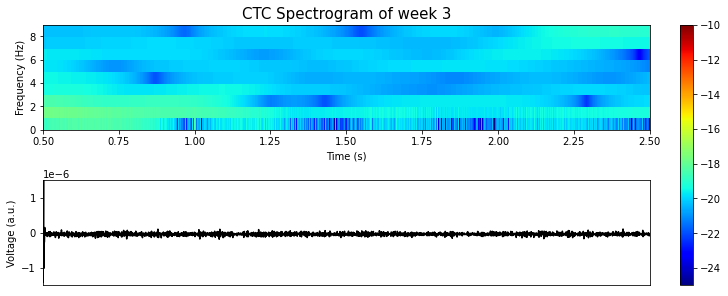

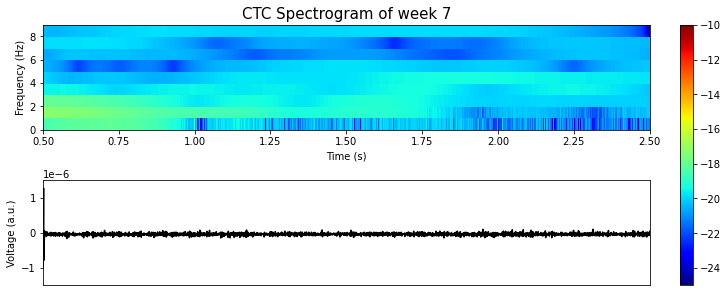

In [61]:
# plot NOVA1 event spectrogram and lfp trace

for i in range(4):

  # Calculate spectrogram of data in limited range
  f, t_spec, x_spec = spectrogram(nova_lfp_events[i], fs=fs_ds, window='hanning', nperseg=1000, noverlap=1000-1, mode='psd')
  t = range(3000)

  # Plot spectrogram
  fmax = 10
  fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10,4))
    
  x_mesh, y_mesh = np.meshgrid(t_spec, f[f<fmax])
  axs[0].set_title('CTC Spectrogram of week ' + str(week[i]),size=15)
  pcm = axs[0].pcolormesh(x_mesh, y_mesh, np.log10(x_spec[f<fmax]), cmap=cm.jet, vmin=-25, vmax=-10)
  axs[0].set_xlabel('Time (s)')
  axs[0].set_ylabel('Frequency (Hz)')
  fig.colorbar(pcm, ax=axs[:], location='right', aspect=50)

  axs[1].plot(t,nova_lfp_events[i],'k')
  axs[1].set_xticks([])
  axs[1].set_ylabel('Voltage (a.u.)')
  axs[1].set_xlim(500, 2500)
  axs[1].set_ylim(-1.5e-6, 1.5e-6)

From the spectrogram, we can observe that CTC organoids have more sustained increase in delta band activity during network events; this might due to the more intense excitatory connection formed between cells in the organoid. After averaging, CTC lfp shows a dip in lfp then increase in lfp, reflecting some common collective activities/mechanisms right after the onset of a network event. But the NOVA1 averaged lfp is mostly flat, which might due to the canceling of different forms of event-related lfp traces, which might indicate heterogeneous activities during network events.

### Delta-Gamma Phase-Amplitude Coupling (PAC)

In previous study (Trujillo et al., 2019), cross-frequency phase-amplitude coupling (PAC) is observed between oscillatory delta
(1–4 Hz) and broadband gamma activity (100–400 Hz) during events. Since PAC has been proposed to be the underlying mechanism for cross-region communication in the brain, the emergence of that may reflect some communication across regions start to form. Here, we want to see if similar PAC exists in early developing period in wild type organoid and NOVA1 variant organoid.

In [62]:
# define bandpass filters borrowed from UCSD COGS189WI21 A1 starter code
def butter_bandpass(lowcut, highcut, fs, order = 2):
  nyq = 0.5 * fs
  low = lowcut/nyq
  high = highcut/nyq
  sos = butter(order, [low, high], analog=False, btype='band', output='sos')
  return sos
def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
  sos = butter_bandpass(lowcut, highcut, fs, order=order)
  y = sosfiltfilt(sos, data)
  return y

In [64]:
file=ctc_files[0]
spikes = np.array(file['spikes'])
lfp = np.array(file['LFP']).flatten()
# bandpass all 64 channels to get delta and gamma
well_id = 4
channel_id = 2
events_t0 = extract_events(well_id, channel_id, file)
lfp = np.array(file[np.array(file['LFP']).flatten()[well_id]])[channel_id, :]
lfp_segs = extract_lfp_seg(lfp, events_t0)
t = np.mean(lfp_segs, axis=0)
delta = butter_bandpass_filter(t, 0.1, 4, fs_ds)
gamma1 = butter_bandpass_filter(t, 100, 200, fs_ds)
gamma2 = butter_bandpass_filter(t, 200, 400, fs_ds)
#Get delta phase (From https://www.gaussianwaves.com/2017/04/extract-envelope-instantaneous-phase-frequency-hilbert-transform/)
z= hilbert(delta) #form the analytical signal
inst_amplitude = np.abs(z) #envelope extraction
delta_phase = np.unwrap(np.angle(z))#inst phase
#Get amplitude envolope of gamma bands, used square instead of square b.c. amplitude too small
gamma1_power = abs(hilbert(gamma1))
gamma2_power = abs(hilbert(gamma2))

Text(0.5, 1.0, 'Sample LFP trace during event')

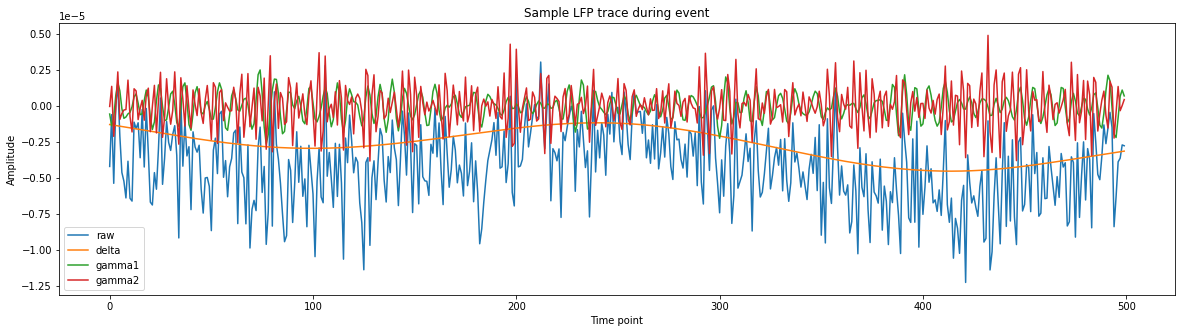

In [65]:
# plot sample lfp trace
begin = 1000
end = 1500
plt.figure(figsize=(20, 5))
plt.plot(t[begin:end], label='raw')
plt.plot(delta[begin:end], label='delta')
plt.plot(gamma1[begin:end], label='gamma1')
plt.plot(gamma2[begin:end], label='gamma2')
plt.legend()
plt.ylabel('Amplitude')
plt.xlabel('Time point')
plt.title('Sample LFP trace during event')

The above plot is a random segment of LFP signal during an event. Delta (orange) and Gamma(100Hz-200Hz and 200Hz-400Hz in green and red, respectively) can be separated out by filtering. The goal is to see whether  the amplitude of two Gamma waves correlate with the phase of the delta wave.

In [66]:
# Code from https://github.com/voytekresearch/Tutorials/blob/master/Spike%20Field%20Coherence%20Tutorial.ipynb
def circCorr(ang,line):
    n = len(ang)
    rxs = pearsonr(line,np.sin(ang))
    rxs = rxs[0]
    rxc = pearsonr(line,np.cos(ang))
    rxc = rxc[0]
    rcs = pearsonr(np.sin(ang),np.cos(ang))
    rcs = rcs[0]
    rho = np.sqrt((rxc**2 + rxs**2 - 2*rxc*rxs*rcs)/(1-rcs**2)) #r
    r_2 = rho**2 #r squared
    pval = 1- chi2.cdf(n*(rho**2),1)
    standard_error = np.sqrt((1-r_2)/(n-2))
    return rho, pval, r_2,standard_error

In [67]:
phase_data = delta_phase
amp_data = gamma2_power
print(circCorr(phase_data, amp_data))

(0.40550026801986105, 0.0, 0.16443046736417916, 0.016694579465631843)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


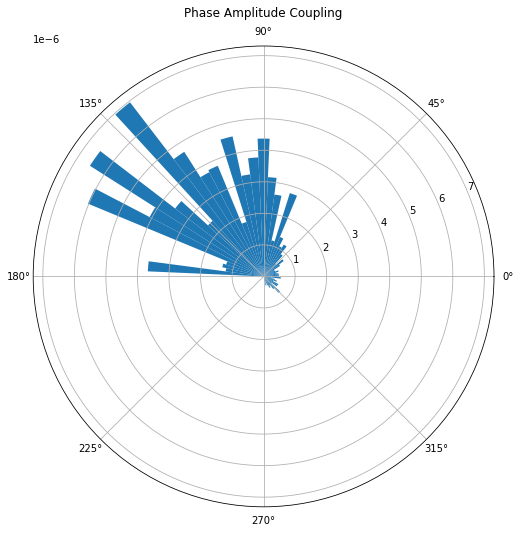

In [68]:
# Plot PAC example
bin_size = 5; 
bins = range(-180,180+bin_size,bin_size); 
bins = np.dot(bins, 0.0174532925);
amps = [];

#filling phase bins with amplitudes
for x in range(len(bins)-1):
    amps_above_lo_bound = np.where(phase_data >= bins[x])[0];
    amps_below_hi_bound = np.where(phase_data < bins[x+1])[0];
    amps_below_hi_bound = set(amps_below_hi_bound);
    amp_inds_in_this_bin = [amp_val for amp_val in amps_above_lo_bound if amp_val in amps_below_hi_bound]
    amps_in_this_bin = amp_data[amp_inds_in_this_bin];
    amps.append(np.nanmean(amps_in_this_bin));

bins = bins[:len(bins)-1];
#plotting figure;
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
ax.bar(bins, amps, width=bins[1]-bins[0], bottom=0.0)
plt.title('Phase Amplitude Coupling');

In this example, there is indeed a delta-gamma PAC tuned to 90-180 degrees specifically. The first two values printed above are rho and p value of PAC, which means there is a significant correlation between delta phase and gamma amplitude that explains about 40% of the variance.

In [69]:
def calc_delta_phase(lfp, lower_bound=0.1, higher_bound=4):
  delta = butter_bandpass_filter(lfp, lower_bound, higher_bound, fs_ds)
  z= hilbert(delta) #form the analytical signal
  inst_amplitude = np.abs(z) #envelope extraction
  delta_phase = np.unwrap(np.angle(z))#inst phase
  return delta_phase

def calc_gamma_power(lfp, lower_bound=100, higher_bound=400, middle_cutoff=200):
  gamma1 = butter_bandpass_filter(lfp, lower_bound, middle_cutoff, fs_ds)
  gamma2 = butter_bandpass_filter(lfp, middle_cutoff, higher_bound, fs_ds)
  gamma1_power = abs(hilbert(gamma1))
  gamma2_power = abs(hilbert(gamma2))
  return gamma1_power, gamma2_power

def get_coupling_phase(phase_data, amp_data, bin_size = 18): 
  bins = range(-180,180+bin_size,bin_size)
  bins = np.dot(bins, 0.0174532925)
  amps = []
  #filling phase bins with amplitudes
  for x in range(len(bins)-1):
      amps_above_lo_bound = np.where(phase_data >= bins[x])[0];
      amps_below_hi_bound = np.where(phase_data < bins[x+1])[0];
      amps_below_hi_bound = set(amps_below_hi_bound);
      amp_inds_in_this_bin = [amp_val for amp_val in amps_above_lo_bound if amp_val in amps_below_hi_bound]
      amps_in_this_bin = amp_data[amp_inds_in_this_bin];
      amps.append(np.nanmean(amps_in_this_bin));
  return np.array(amps)

def get_all_pac(file, pval_cutoff = 0.001):
  corr_gamma1 = []
  corr_gamma2 = []
  gamma1_coupling = []
  gamma2_coupling = []
  for well_id in tqdm(range(num_wells)):
    channel_corr1 = []
    channel_corr2 = []
    channel_coupling1 = []
    channel_coupling2 = []
    for channel_id in range(num_channels):
      events_t0 = extract_events(well_id, channel_id, file)
      if len(events_t0)>0:
        lfp = np.array(file[np.array(file['LFP']).flatten()[well_id]])[channel_id, :]
        lfp_segs = extract_lfp_seg(lfp, events_t0)
        lfp = np.nanmean(lfp_segs, axis=0)
        delta_phase = calc_delta_phase(lfp)
        gamma1_power, gamma2_power = calc_gamma_power(lfp)
        corr1, pval1, _, _ = circCorr(delta_phase, gamma1_power)
        corr2, pval2, _, _ = circCorr(delta_phase, gamma2_power)
        amps1 = get_coupling_phase(delta_phase, gamma1_power)
        amps2 = get_coupling_phase(delta_phase, gamma2_power)
        if pval1 < pval_cutoff:
          channel_corr1.append(corr1)
          channel_coupling1.append(amps1)
        if pval2 < pval_cutoff:
          channel_corr2.append(corr2)
          channel_coupling2.append(amps2)
    corr_gamma1.append(np.array(channel_corr1))
    corr_gamma2.append(np.array(channel_corr2))
    if len(channel_coupling1)!=0:
      gamma1_coupling.append(channel_coupling1)
    if len(channel_coupling2)!=0:
      gamma2_coupling.append(channel_coupling2)
  flat_corr1 = np.hstack(corr_gamma1)
  flat_corr2 = np.hstack(corr_gamma2)
  mean_coupling1 = np.nanmean(np.vstack(gamma1_coupling), axis=0)
  mean_coupling2 = np.nanmean(np.vstack(gamma2_coupling), axis=0)
  corr_stats = {'gamma1_mean':np.nanmean(flat_corr1), 'gamma1_std':np.nanstd(flat_corr1), 'gamma2_mean':np.nanmean(flat_corr2), 'gamma2_std':np.nanstd(flat_corr2)}
  return corr_stats, list(mean_coupling1), list(mean_coupling2)

In [70]:
time_points = ['week0', 'week1', 'week3', 'week7']
rerun_pac = 0
if rerun_pac:
  ctc_pac = {}
  for i in range(len(ctc_files)):
    pac = {}
    print('Calculating PAC for Wild Type File #%d'%i)
    corr_stats, mean_coupling1, mean_coupling2 = get_all_pac(ctc_files[i])
    pac['stats'] = corr_stats
    pac['gamma1_mean'] = mean_coupling1
    pac['gamma2_mean'] = mean_coupling2
    ctc_pac[time_points[i]] = pac
  with open('/content/drive/My Drive/NOVA1_LFP/ctc_pac.json', 'w') as outfile:  
    json.dump(ctc_pac, outfile) 

In [71]:
if rerun_pac:
  nova_pac = {}
  for i in range(len(nova_files)):
    pac = {}
    print('Calculating PAC for NOVA1 File #%d'%i)
    corr_stats, mean_coupling1, mean_coupling2 = get_all_pac(nova_files[i])
    pac['stats'] = corr_stats
    pac['gamma1_mean'] = mean_coupling1
    pac['gamma2_mean'] = mean_coupling2
    nova_pac[time_points[i]] = pac
  with open('/content/drive/My Drive/NOVA1_LFP/nova_pac.json', 'w') as outfile:  
    json.dump(nova_pac, outfile) 

In [72]:
rerun_pac = 0
if not rerun_pac:
  with open('/content/drive/My Drive/NOVA1_LFP/nova_pac.json') as f:
    nova_pac = json.load(f)
  with open('/content/drive/My Drive/NOVA1_LFP/ctc_pac.json') as f:
    ctc_pac = json.load(f)

In [73]:
def extract_mean_std_pac(pac_dict):
  gamma1_mean = []
  gamma2_mean = []
  gamma1_std = []
  gamma2_std = []
  for k in pac_dict.keys():
    gamma1_mean.append(pac_dict[k]['stats']['gamma1_mean'])
    gamma2_mean.append(pac_dict[k]['stats']['gamma2_mean'])
    gamma1_std.append(pac_dict[k]['stats']['gamma1_std'])
    gamma2_std.append(pac_dict[k]['stats']['gamma2_std'])
  return gamma1_mean, gamma1_std, gamma2_mean, gamma2_std

def extract_mean_coupling(pac_dict):
  gamma1_cp = []
  gamma2_cp = []
  for k in pac_dict.keys():
    gamma1_cp.append(pac_dict[k]['gamma1_mean'])
    gamma2_cp.append(pac_dict[k]['gamma2_mean'])
  return gamma1_cp, gamma2_cp

In [74]:
nova_gamma1_mean, nova_gamma1_std, nova_gamma2_mean, nova_gamma2_std = extract_mean_std_pac(nova_pac)
ctc_gamma1_mean, ctc_gamma1_std, ctc_gamma2_mean, ctc_gamma2_std = extract_mean_std_pac(ctc_pac)

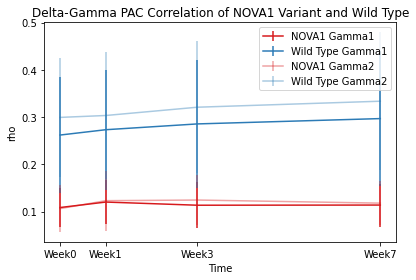

In [76]:
plt.errorbar([1, 2, 4, 8], nova_gamma1_mean, yerr=nova_gamma1_std, c='#D7191C', label='NOVA1 Gamma1')
plt.errorbar([1, 2, 4, 8], ctc_gamma1_mean, yerr=ctc_gamma1_std, c='#2C7BB6', label='Wild Type Gamma1')
plt.errorbar([1, 2, 4, 8], nova_gamma2_mean, yerr=nova_gamma2_std, c='#D7191C', alpha=0.4, label='NOVA1 Gamma2')
plt.errorbar([1, 2, 4, 8], ctc_gamma2_mean, yerr=ctc_gamma2_std, c='#2C7BB6', alpha=0.4, label='Wild Type Gamma2')
plt.xticks(labels=['Week0','Week1','Week3','Week7'], ticks=[1, 2, 4, 8])
plt.xlabel('Time')
plt.ylabel('rho')
plt.legend(loc='best')
plt.title('Delta-Gamma PAC Correlation of NOVA1 Variant and Wild Type')
plt.tight_layout()

From the plot, it is clear that the wild type have higher PAC than NOVA1 orgaoid in general. While the PAC for wild type has a slight increase cross time, indicating there may exist a increase in communication between regions, the PAC for NOVA1 stays roughly the same at a low level for the entire 7-week period.

In [ ]:
nova_gamma1_cp, nova_gamma2_cp = extract_mean_coupling(nova_pac)
ctc_gamma1_cp, ctc_gamma2_cp = extract_mean_coupling(ctc_pac)
nova_g1cp_mean = np.nanmean(nova_gamma1_cp, axis=0)
nova_g2cp_mean = np.nanmean(nova_gamma2_cp, axis=0)
ctc_g1cp_mean = np.nanmean(ctc_gamma1_cp, axis=0)
ctc_g2cp_mean = np.nanmean(ctc_gamma2_cp, axis=0)

Text(0.5, 0.98, 'Mean Gamma Amplitude in Each Delta Phase Bin')

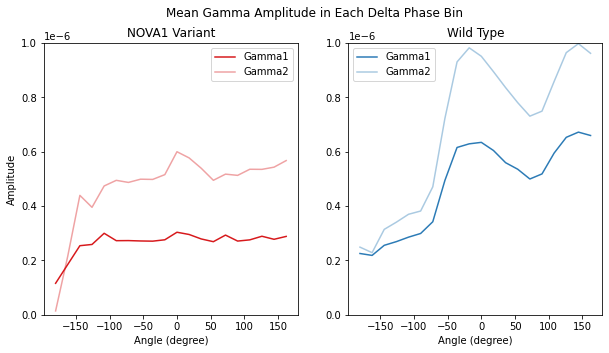

In [ ]:
bin_size = 18
x_ticks = range(-180,180,bin_size)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x_ticks, nova_g1cp_mean, c='#D7191C', label='Gamma1')
plt.plot(x_ticks, nova_g2cp_mean, c='#D7191C', alpha=0.4, label='Gamma2')
plt.xlabel('Angle (degree)')
plt.ylabel('Amplitude')
plt.ylim([0,1e-6])
plt.title('NOVA1 Variant')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(x_ticks, ctc_g1cp_mean, c='#2C7BB6', label='Gamma1')
plt.plot(x_ticks, ctc_g2cp_mean, c='#2C7BB6', alpha=0.4, label='Gamma2')
plt.xlabel('Angle (degree)')
plt.ylim([0,1e-6])
plt.title('Wild Type')
plt.legend(loc='best')
plt.suptitle('Mean Gamma Amplitude in Each Delta Phase Bin')

Similarly, if we plot the delta phase tha the gamma amplitudes are tuned on average, it is clear that NOVA1 organoid does not have a distinct preference, probably due to its low coherence while wild type organoid has a preference to -50 to 50 degrees and 100 to 180 degrees on average. 

## Conclusion & Discussion

Our results mostly agree with the claim about slow development and high network complexity of NOVA1 variant organoid in Trujillo et al.,2021. In addition, we did find some signs of neural oscillation in the wild type organoid as early as week 7 while the origional paper (Trujillo et al.,2019) only showed this property for 10+ week organoids. Delta oscillation was found in both types of organoids, but only the wild type exibits delta-gamma phase-amplitude coupling.

As mentioned previously, great limitations lie beneath our analysis. Since we don't know the exact start date of the recording. It is very likely that we are comparing two organoids with different developing stages. Therefore, the advanced developments of wild type organoids are likely due to the reason that its data is indeed from a later time period. This could also potentially explains why the spiking rate of NOVA1 variant is lower than that of the wild type while the situation is the opposite in Trujillo et al.,2021. Also, since we only have 4 recordings for each organoid, some of the trends we show here may not hold if we have recordings from more time points from multiple organoids.

Besides the issue with the data, the transferablity of the conclusion to actual human brain development is unkown. To fully understand the significance of our findings, more research on the literature of this topic needs to be done.

In the near future, we are hoping to extend our analysis further. First, we are planning to include more data with confirmed development period if possible. If we can also find the original spiking data from MEA recording, we could refine our criteria of defining network events for the existing analysis and also have a deeper understanding about the data with much more analysis options. 
If that data is not available, we want to explore more LFP analysis methods like FOOOF with our current dataset. In addition, some of the information, such as average spike, in our current dataset is unused in this project. Leveraging these data could possibly lead us to a clearer path.


